In [1]:
# KAGGLE DOWNLOADING DELETED
# LOCAL DOWNLOAD FROM LOCAL FILES IMPLEMENTED

## Preparation

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import json
import pathlib

In [3]:
def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)

set_all_seeds(42)

### Загрузка и обработка данных

In [4]:
base_path = pathlib.Path('data/you-are-bot')

path_train = base_path / 'train.json'
path_test = base_path / 'test.json'

path_y_train = base_path / 'ytrain.csv'
path_y_test = base_path / 'ytest.csv'

path_sample_submission = base_path / 'sample_submission.csv'

with open(path_train, 'r') as f:
    train_data = json.load(f)

with open(path_test, 'r') as f:
    test_data = json.load(f)

submission = pd.read_csv(path_sample_submission)
y_train_data = pd.read_csv(path_y_train)
y_test_data = pd.read_csv(path_y_test)

print("Number of training samples:", len(train_data))
print("Number of test samples:", len(test_data))

rename_map = {"participant_index" : 'person'}

dataset_train = []

for dialog_id, dialog in train_data.items():
    mask = y_train_data['dialog_id'] == dialog_id
    # Ensure that labels are sorted by participant_index
    y = y_train_data[mask][['participant_index', 'is_bot']].sort_values(by='participant_index', ascending=1)['is_bot'].to_list()
    # Creating labels
    p0_bot = str(int(y[0]))
    p1_bot = str(int(y[1]))
    s = p0_bot + p1_bot
    label_map = {
        '01' : 0, # p0 human, p1 bot
        '10' : 1, # p0 bot, p1 human
        '00' : 2, # both human
    }
    label = label_map[s]
    # Rename keys in dialog items
    rename_set_keys = lambda s, names : {names.get(k, k): v for k, v in s.items()}
    dialog = [rename_set_keys(item, rename_map) for item in dialog]
    # Create data entry
    data = {
        'dialog': dialog,
        'label': label,
        'dialog_id': dialog_id,
        'p0_bot': int(p0_bot),
        'p1_bot': int(p1_bot),
    }
    dataset_train.append(data)

dataset_test = []
for dialog_id, dialog in test_data.items():
    dialog = [rename_set_keys(item, rename_map) for item in dialog]
    data = {
        'dialog': dialog,
        'dialog_id': dialog_id,
    }
    dataset_test.append(data)

df_train = pd.DataFrame(dataset_train)
df_test = pd.DataFrame(dataset_test)

df_train.head(3)

Number of training samples: 786
Number of test samples: 338


,dialog,label,dialog_id,p0_bot,p1_bot
0,"[{'message': 0, 'text': 'Hello!', 'person': '0...",2,dae9e2dae9f840549764f8d9bbbb80f0,0,0
1,"[{'message': 0, 'text': 'Привет', 'person': '0...",0,159da0d7937c4c1e84a51f0df7e3ade6,0,1
2,"[{'message': 0, 'text': 'Привет', 'person': '0...",0,1aed86f082234446951360d00979f0d9,0,1


### Графики

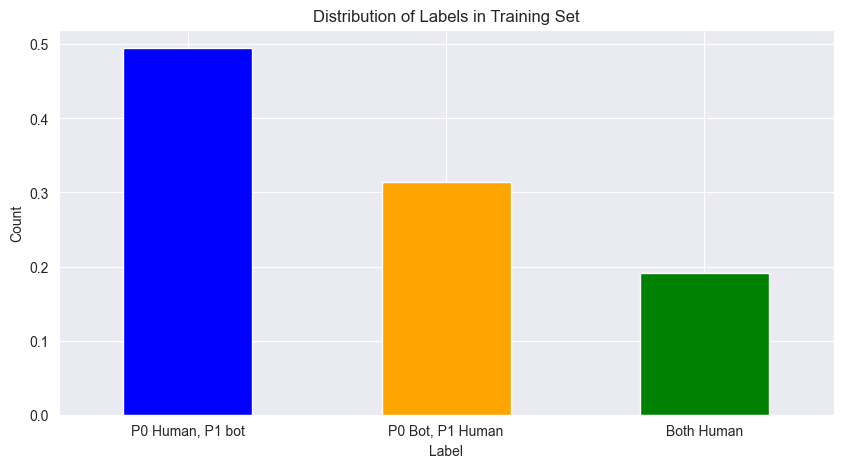

In [5]:
# Распределение меток
plt.figure(figsize=(10, 5))
df_train['label'].value_counts(normalize=True).plot(kind='bar', color=['blue', 'orange', 'green'])
plt.title('Distribution of Labels in Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['P0 Human, P1 bot', 'P0 Bot, P1 Human', 'Both Human'], rotation=0)
plt.show()

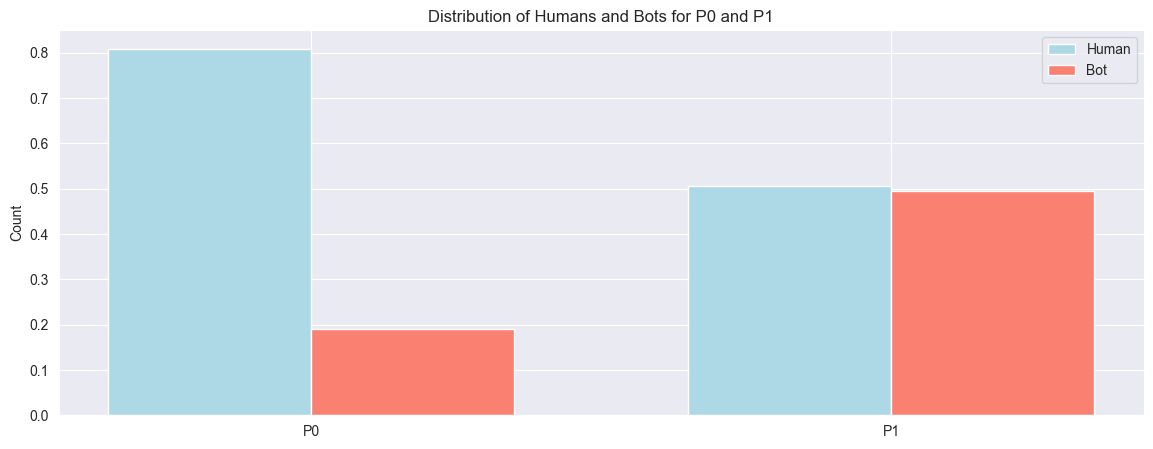

In [6]:
# Calculate counts for P0 and P1: human vs bot
p0_counts = df_train['p0_bot'].value_counts().sort_index()
p1_counts = df_train['p1_bot'].value_counts().sort_index()

# Prepare data for barplot
counts = [
    [p0_counts.get(0, 0), p0_counts.get(1, 0)],  # P0: [human, bot]
    [p1_counts.get(0, 0), p1_counts.get(1, 0)],  # P1: [human, bot]
]
counts = np.array(counts) / np.array(counts).sum(axis=1, keepdims=True)
labels = ['P0', 'P1']
categories = ['Human', 'Bot']

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(14, 5))
plt.bar(x - width/2, [c[0] for c in counts], width, label='Human', color='lightblue')
plt.bar(x + width/2, [c[1] for c in counts], width, label='Bot', color='salmon')
plt.xticks(x, labels)
plt.ylabel('Count')
plt.title('Distribution of Humans and Bots for P0 and P1')
plt.legend()
plt.show()

### Инструменты для анализа диалогов вручную

In [7]:
def get_dialog_by_id(id):
    # Using df_train
    row = df_train.iloc[id]
    dialog = row['dialog']
    label = row['label']
    return dialog, label

get_dialog_by_id(4)

([{'message': 0, 'text': 'привет', 'person': '0'},
  {'message': 1, 'text': 'ок', 'person': '1'},
  {'message': 2, 'text': 'ок', 'person': '0'},
  {'message': 3, 'text': 'кок', 'person': '1'},
  {'message': 4, 'text': 'кок', 'person': '0'},
  {'message': 5, 'text': 'биг ывс', 'person': '1'},
  {'message': 6, 'text': 'биг ывс', 'person': '0'},
  {'message': 7, 'text': 'не повторяйся', 'person': '1'},
  {'message': 8, 'text': 'прости, я не бот', 'person': '0'},
  {'message': 9, 'text': 'эх', 'person': '1'},
  {'message': 10, 'text': 'эх', 'person': '0'}],
 np.int64(1))

In [8]:
def render_dialog(dialog):
    for item in dialog:
        person = item['person']
        text = item['text']
        print(f"{person}: {text}")

def get_dialog_by_label(label, id=0):
    mask = df_train['label'] == label
    dialog_id = df_train[mask]['dialog_id'].reset_index(drop=True)[id]
    dialog = df_train[mask]['dialog'].reset_index(drop=True)[id]

    print("Dialog ID:", dialog_id)
    print()
    render_dialog(dialog)
    print()

    mask = y_train_data['dialog_id'] == dialog_id
    data = y_train_data[mask][['dialog_id', 'participant_index', 'is_bot']]
    data = data.sort_values(by='participant_index').reset_index(drop=True)
    p0_bot = data['is_bot'][0]
    p1_bot = data['is_bot'][1]
    print("0 bot:", p0_bot)
    print("1 bot:", p1_bot)

get_dialog_by_label(1, 41)

Dialog ID: 28728a1e986a4495aea870cc123df193

0: Привет! Как твои дела? Чем сегодня занимаешься?
1: Я изучаю как происходит северное сияние
0: Северное сияние — это удивительное явление, которое всегда завораживает. По сути, это световое шоу, устроенное Солнцем и нашими магнитным полем и атмосферой. Когда заряженные частицы, в основном электроны и протоны, из солнечного ветра достигают Земли, они сталкиваются с атомами и молекулами в верхних слоях атмосферы. Эти столкновения высвобождают энергию в виде света, и мы видим разноцветные полосы в небе. Цвета зависят от того, с какими именно атомами или молекулами происходит взаимодействие: например, кислород дает зеленый и красный свет, а азот — синий и фиолетовый. А ты о чем-то конкретном хотел узнать? Может, какого цвета сияние видят чаще всего или когда его лучше наблюдать?
1: спасибо, друг
0: Всегда рад помочь! Если ещё останутся вопросы или захочется пообщаться, обращайся. Какое ещё увлечение захватывает твое внимание?
1: Какая ты модел

### Добавляем фичи

In [9]:
def add_dialog_length(df):
    df['dialog_length'] = df['dialog'].apply(lambda x: len(x))
    return df

df_train = add_dialog_length(df_train)
df_test = add_dialog_length(df_test)

df_train.head(3)

,dialog,label,dialog_id,p0_bot,p1_bot,dialog_length
0,"[{'message': 0, 'text': 'Hello!', 'person': '0...",2,dae9e2dae9f840549764f8d9bbbb80f0,0,0,5
1,"[{'message': 0, 'text': 'Привет', 'person': '0...",0,159da0d7937c4c1e84a51f0df7e3ade6,0,1,14
2,"[{'message': 0, 'text': 'Привет', 'person': '0...",0,1aed86f082234446951360d00979f0d9,0,1,4


In [10]:
def add_messages_by_persons(df):
    df['p0_messages'] = df['dialog'].apply(lambda x: [msg['text'] for msg in x if msg['person'] == '0'])
    df['p1_messages'] = df['dialog'].apply(lambda x: [msg['text'] for msg in x if msg['person'] == '1'])
    return df

df_train = add_messages_by_persons(df_train)
df_test = add_messages_by_persons(df_test)

df_train.head(3)

,dialog,label,dialog_id,p0_bot,p1_bot,dialog_length,p0_messages,p1_messages
0,"[{'message': 0, 'text': 'Hello!', 'person': '0...",2,dae9e2dae9f840549764f8d9bbbb80f0,0,0,5,"[Hello!, Отлично! А твои?, Расскажи теорему]","[Как дела?, Это круто!]"
1,"[{'message': 0, 'text': 'Привет', 'person': '0...",0,159da0d7937c4c1e84a51f0df7e3ade6,0,1,14,"[Привет, никак, оооокккееуу, оууукккии, оооууу...","[Привет! Как я могу помочь тебе сегодня?, Хоро..."
2,"[{'message': 0, 'text': 'Привет', 'person': '0...",0,1aed86f082234446951360d00979f0d9,0,1,4,"[Привет, Ты бот?]","[Как дела?, сын божий. А ты?]"


In [11]:
import emoji

def count_emoji(text):
    return len([c for c in text if c in emoji.EMOJI_DATA])

def add_text_features(df):
    # Pure text
    df['p0_text'] = df['p0_messages'].apply(lambda x: ' '.join(x))
    df['p1_text'] = df['p1_messages'].apply(lambda x: ' '.join(x))
    # Emoji count
    df['p0_emoji_count'] = df['p0_text'].apply(count_emoji)
    df['p1_emoji_count'] = df['p1_text'].apply(count_emoji)
    # Percent of messages with emojis
    df['p0_emoji_percent'] = df['p0_messages'].apply(lambda x: sum(1 if count_emoji(msg) > 0 else 0 for msg in x) / len(x) if len(x) > 0 else 0)
    df['p1_emoji_percent'] = df['p1_messages'].apply(lambda x: sum(1 if count_emoji(msg) > 0 else 0 for msg in x) / len(x) if len(x) > 0 else 0)
    # Mean length of messages
    df['p0_mean_length'] = df['p0_messages'].apply(lambda x: np.mean([len(msg) for msg in x]) if x else 0)
    df['p1_mean_length'] = df['p1_messages'].apply(lambda x: np.mean([len(msg) for msg in x]) if x else 0)
    # Count of special characters: ? !
    special_chars = ['?', '!']
    df['p0_special_count'] = df['p0_text'].apply(lambda x: sum(x.count(char) for char in special_chars) / len(x) if len(x) > 0 else 0)
    df['p1_special_count'] = df['p1_text'].apply(lambda x: sum(x.count(char) for char in special_chars) / len(x) if len(x) > 0 else 0)
    # Percent of first capital letter in messages
    df['p0_first_capital_percent'] = df['p0_messages'].apply(lambda x: sum(1 if len(msg) > 0 and msg[0].isupper() else 0 for msg in x) / len(x) if len(x) > 0 else 0)
    df['p1_first_capital_percent'] = df['p1_messages'].apply(lambda x: sum(1 if len(msg) > 0 and msg[0].isupper() else 0 for msg in x) / len(x) if len(x) > 0 else 0)
    # Percent of capital letters in messages
    df['p0_capital_percent'] = df['p0_text'].apply(lambda x: sum(1 if c.isupper() else 0 for c in x) / len(x) if len(x) > 0 else 0)
    df['p1_capital_percent'] = df['p1_text'].apply(lambda x: sum(1 if c.isupper() else 0 for c in x) / len(x) if len(x) > 0 else 0)
    # Mean words length in messages
    df['p0_mean_words_length'] = df['p0_text'].apply(lambda x: np.mean([len(word) for word in x.split()]) if len(x) > 0 else 0)
    df['p1_mean_words_length'] = df['p1_text'].apply(lambda x: np.mean([len(word) for word in x.split()]) if len(x) > 0 else 0)
    # Mean count of words in messages
    df['p0_mean_words_count'] = df['p0_text'].apply(lambda x: np.mean([len(msg.split()) for msg in x.split('\n')]) if len(x) > 0 else 0)
    df['p1_mean_words_count'] = df['p1_text'].apply(lambda x: np.mean([len(msg.split()) for msg in x.split('\n')]) if len(x) > 0 else 0)
    # Drop pure text columns
    df.drop(columns=['p0_text', 'p1_text'], inplace=True)

    return df

df_train = add_text_features(df_train)
df_test = add_text_features(df_test)

df_train.head(3)


,dialog,label,dialog_id,p0_bot,p1_bot,dialog_length,p0_messages,p1_messages,p0_emoji_count,p1_emoji_count,...,p0_special_count,p1_special_count,p0_first_capital_percent,p1_first_capital_percent,p0_capital_percent,p1_capital_percent,p0_mean_words_length,p1_mean_words_length,p0_mean_words_count,p1_mean_words_count
0,"[{'message': 0, 'text': 'Hello!', 'person': '0...",2,dae9e2dae9f840549764f8d9bbbb80f0,0,0,5,"[Hello!, Отлично! А твои?, Расскажи теорему]","[Как дела?, Это круто!]",0,0,...,0.075000,0.100000,1.000000,1.0,0.100000,0.100000,5.833333,4.25,6.0,4.0
1,"[{'message': 0, 'text': 'Привет', 'person': '0...",0,159da0d7937c4c1e84a51f0df7e3ade6,0,1,14,"[Привет, никак, оооокккееуу, оууукккии, оооууу...","[Привет! Как я могу помочь тебе сегодня?, Хоро...",0,0,...,0.000000,0.010903,0.142857,1.0,0.015385,0.021807,8.428571,5.43,7.0,100.0
2,"[{'message': 0, 'text': 'Привет', 'person': '0...",0,1aed86f082234446951360d00979f0d9,0,1,4,"[Привет, Ты бот?]","[Как дела?, сын божий. А ты?]",0,0,...,0.071429,0.076923,1.000000,0.5,0.142857,0.076923,4.000000,3.50,3.0,6.0


In [12]:
def add_echo_bot_index(df):
    # For p0 and p1 count how many their is echo of previous messages
    def echo_count(dialog):
        p0_echo_count = 0
        p1_echo_count = 0
        prev_text = None
        for msg in dialog:
            text = msg['text']
            person = msg['person']
            if prev_text and text == prev_text:
                if person == '0':
                    p0_echo_count += 1
                elif person == '1':
                    p1_echo_count += 1
            prev_text = text
        return p0_echo_count, p1_echo_count

    df['temp'] = df['dialog'].apply(echo_count)
    p0_echo_count = df['temp'].apply(lambda x: x[0])
    p1_echo_count = df['temp'].apply(lambda x: x[1])
    df.drop(columns=['temp'], inplace=True)

    df['p0_echo_index'] = p0_echo_count / df['p0_messages'].apply(lambda x: len(x) - 1 if len(x) > 1 else 1)
    df['p1_echo_index'] = p1_echo_count / df['p1_messages'].apply(lambda x: len(x) if len(x) > 0 else 1)
    return df

df_train = add_echo_bot_index(df_train)
df_test = add_echo_bot_index(df_test)

df_train.head(3)

,dialog,label,dialog_id,p0_bot,p1_bot,dialog_length,p0_messages,p1_messages,p0_emoji_count,p1_emoji_count,...,p0_first_capital_percent,p1_first_capital_percent,p0_capital_percent,p1_capital_percent,p0_mean_words_length,p1_mean_words_length,p0_mean_words_count,p1_mean_words_count,p0_echo_index,p1_echo_index
0,"[{'message': 0, 'text': 'Hello!', 'person': '0...",2,dae9e2dae9f840549764f8d9bbbb80f0,0,0,5,"[Hello!, Отлично! А твои?, Расскажи теорему]","[Как дела?, Это круто!]",0,0,...,1.000000,1.0,0.100000,0.100000,5.833333,4.25,6.0,4.0,0.0,0.0
1,"[{'message': 0, 'text': 'Привет', 'person': '0...",0,159da0d7937c4c1e84a51f0df7e3ade6,0,1,14,"[Привет, никак, оооокккееуу, оууукккии, оооууу...","[Привет! Как я могу помочь тебе сегодня?, Хоро...",0,0,...,0.142857,1.0,0.015385,0.021807,8.428571,5.43,7.0,100.0,0.0,0.0
2,"[{'message': 0, 'text': 'Привет', 'person': '0...",0,1aed86f082234446951360d00979f0d9,0,1,4,"[Привет, Ты бот?]","[Как дела?, сын божий. А ты?]",0,0,...,1.000000,0.5,0.142857,0.076923,4.000000,3.50,3.0,6.0,0.0,0.0


## Learn & Predict

### Подготовка данных для обучения модели

In [13]:
X_train = df_train.copy()
y_train = df_train['label'].copy()

X_test = df_test.copy()

def columns_filter(df):
    BLACKLIST = [
        'dialog', 'p0_messages', 'p1_messages',
        'label', 'p0_bot', 'p1_bot', 'dialog_id',
    ]
    cols = df.columns.tolist()
    cols = [col for col in cols if col not in BLACKLIST]
    return df[cols]

X_train = columns_filter(X_train)
X_test = columns_filter(X_test)

cols_order = X_train.columns.tolist()
X_test = X_test[cols_order]

X_train.head(3)

,dialog_length,p0_emoji_count,p1_emoji_count,p0_emoji_percent,p1_emoji_percent,p0_mean_length,p1_mean_length,p0_special_count,p1_special_count,p0_first_capital_percent,p1_first_capital_percent,p0_capital_percent,p1_capital_percent,p0_mean_words_length,p1_mean_words_length,p0_mean_words_count,p1_mean_words_count,p0_echo_index,p1_echo_index
0,5,0,0,0.0,0.0,12.666667,9.500000,0.075000,0.100000,1.000000,1.0,0.100000,0.100000,5.833333,4.25,6.0,4.0,0.0,0.0
1,14,0,0,0.0,0.0,8.428571,90.857143,0.000000,0.010903,0.142857,1.0,0.015385,0.021807,8.428571,5.43,7.0,100.0,0.0,0.0
2,4,0,0,0.0,0.0,6.500000,12.500000,0.071429,0.076923,1.000000,0.5,0.142857,0.076923,4.000000,3.50,3.0,6.0,0.0,0.0


### Обучение моделей

### K-folds

In [14]:
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, log_loss
from tqdm import tqdm

def split_labels(y):
    label1 = y == 1  # P0 bot, P1 human => label1 = p0_bot
    label2 = y == 0  # P0 human, P1 bot => label2 = p1_bot
    return label1.astype(int), label2.astype(int)

def get_models():
    return {
        'lgm': lgb.LGBMClassifier(verbose=-1, random_state=42),
        'xgb': xgb.XGBClassifier(eval_metric='logloss', random_state=42),
        'cat': cat.CatBoostClassifier(verbose=0, random_state=42),
        'rf': RandomForestClassifier(random_state=42),
        'lr': make_pipeline(
                StandardScaler(),
                LogisticRegression(max_iter=1000)
              ),
    }


def add_probs_to_df(df, probs1, probs2, name, indexes=None):
    if indexes is None:
        indexes = df.index.tolist()
    if f'p0_prob_{name}' not in df.columns:
        df[f'p0_prob_{name}'] = np.nan
    if f'p1_prob_{name}' not in df.columns:
        df[f'p1_prob_{name}'] = np.nan
    df.loc[df.index[indexes], f'p0_prob_{name}'] = probs1[:, 1]  # P0 bot probability
    df.loc[df.index[indexes], f'p1_prob_{name}'] = probs2[:, 1]  # P1 bot probability


X = X_train.copy()
y1, y2 = split_labels(y_train)

X_train2 = X.copy()
X_test2 = X_test.copy()

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

names = list(get_models().keys())
test_probs1 = {name: np.zeros((len(X_test), 2)) for name in names}
test_probs2 = {name: np.zeros((len(X_test), 2)) for name in names}

folds_data = []
feature_importance_data = {name : [] for name in names}

for fold, (train_index, val_index) in tqdm(enumerate(kf.split(X)), desc="KFold Progress", total=k):
    X_train_fold = X.iloc[train_index]
    y1_train_fold = y1.iloc[train_index]
    y2_train_fold = y2.iloc[train_index]

    X_val_fold = X.iloc[val_index]
    y1_val_fold = y1.iloc[val_index]
    y2_val_fold = y2.iloc[val_index]

    # Here you can train your model on X_train_fold and validate on X_val_fold
    models1 = get_models()
    models2 = get_models()

    val_acc1 = []
    val_acc2 = []
    val_logloss1 = []
    val_logloss2 = []

    for name in names:
        tmp_model1 = models1[name]
        tmp_model2 = models2[name]

        tmp_model1.fit(X_train_fold, y1_train_fold)
        tmp_model2.fit(X_train_fold, y2_train_fold)

        probs1 = tmp_model1.predict_proba(X_val_fold)
        probs2 = tmp_model2.predict_proba(X_val_fold)

        val_acc1.append(accuracy_score(y1_val_fold, tmp_model1.predict(X_val_fold)))
        val_acc2.append(accuracy_score(y2_val_fold, tmp_model2.predict(X_val_fold)))
        val_logloss1.append(log_loss(y1_val_fold, probs1))
        val_logloss2.append(log_loss(y2_val_fold, probs2))

        add_probs_to_df(X_train2, probs1, probs2, name, val_index)

        probs1 = tmp_model1.predict_proba(X_test2)
        probs2 = tmp_model2.predict_proba(X_test2)

        test_probs1[name] += probs1 / k
        test_probs2[name] += probs2 / k

    val_acc1 = np.mean(val_acc1)
    val_acc2 = np.mean(val_acc2)
    val_logloss1 = np.mean(val_logloss1)
    val_logloss2 = np.mean(val_logloss2)
    folds_data.append({
        'fold': fold + 1,
        'val_acc1': val_acc1,
        'val_acc2': val_acc2,
        'val_logloss1': val_logloss1,
        'val_logloss2': val_logloss2,
    })

# Add test probabilities to X_test
for name in names:
    add_probs_to_df(X_test2, test_probs1[name], test_probs2[name], name)

folds_data = pd.DataFrame(folds_data)

print("Accuracy:")
print(f'    P0  : {folds_data["val_acc1"].mean():.4f}')
print(f'    P1  : {folds_data["val_acc2"].mean():.4f}')
print(f"    Avg : {np.mean([folds_data['val_acc1'].mean(), folds_data['val_acc2'].mean()]):.4f}")
print("Log Loss:")
print(f'    P0  : {folds_data["val_logloss1"].mean():.4f}')
print(f'    P1  : {folds_data["val_logloss2"].mean():.4f}')
print(f"    Avg : {np.mean([folds_data['val_logloss1'].mean(), folds_data['val_logloss2'].mean()]):.4f}")

folds_data

KFold Progress: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]

Accuracy:
    P0  : 0.8448
    P1  : 0.7738
    Avg : 0.8093
Log Loss:
    P0  : 0.3990
    P1  : 0.5362
    Avg : 0.4676


,fold,val_acc1,val_acc2,val_logloss1,val_logloss2
0,1,0.856962,0.751899,0.368197,0.603348
1,2,0.850955,0.808917,0.354395,0.463161
2,3,0.808917,0.771975,0.459448,0.543431
3,4,0.833121,0.726115,0.486765,0.590437
4,5,0.873885,0.810191,0.326198,0.480745


In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def get_stats(y_true, y_pred, show_cm=True, names=None):
    names = ['p1 bot', 'p0 bot', 'both human'] if names is None else names
    acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=names)
    cm = confusion_matrix(y_true, y_pred)

    print("Accuracy:", acc)
    print("\nClassification Report:\n", report)

    if show_cm:
        # Show confusion matrix as a heatmap
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=names,
                    yticklabels=names)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.show()

    return acc

In [16]:
# TF-IDF
import re
from sklearn.feature_extraction.text import TfidfVectorizer


def get_texts_p0(df):
    return df['p0_messages'].apply(lambda x: '\n'.join(x)).to_list()

def get_texts_p1(df):
    return df['p1_messages'].apply(lambda x: '\n'.join(x)).to_list()

def get_bot_texts(df):
    df = df.copy()
    p0_bot = df['p0_bot'] == 1
    p1_bot = df['p1_bot'] == 1
    texts1 = get_texts_p0(df[p0_bot])
    texts2 = get_texts_p1(df[p1_bot])
    return texts1 + texts2

def get_human_texts(df):
    df = df.copy()
    p0_bot = df['p0_bot'] == 0
    p1_bot = df['p1_bot'] == 0
    texts1 = get_texts_p0(df[p0_bot])
    texts2 = get_texts_p1(df[p1_bot])
    return texts1 + texts2

def preprocess(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Удалить ссылки
    text = re.sub(r'\s+', ' ', text)                   # Удалить лишние пробелы
    text = re.sub(r'[^\w\s]', '', text)                # Удалить пунктуацию
    return text.strip()

def get_tfidf_probs(df, vectorizer, model_tfidf):
    texts1 = get_texts_p0(df)
    texts2 = get_texts_p1(df)

    texts1 = [preprocess(text) for text in texts1]
    texts2 = [preprocess(text) for text in texts2]

    vec1 = vectorizer.transform(texts1)
    vec2 = vectorizer.transform(texts2)

    probs1 = model_tfidf.predict_proba(vec1)
    probs2 = model_tfidf.predict_proba(vec2)

    return probs1, probs2


y1, y2 = split_labels(y_train)

folds_data_tfidf = []
test_probs1 = np.zeros((len(X_test2), 2))
test_probs2 = np.zeros((len(X_test2), 2))

for fold, (train_indexes, val_indexes) in tqdm(enumerate(kf.split(X_train)), desc="KFold Progress", total=k):
    # Split data into training and validation sets
    X_train_fold = df_train.copy().iloc[train_indexes]
    y1_train_fold = y1.iloc[train_indexes]
    y2_train_fold = y2.iloc[train_indexes]

    X_val_fold = df_train.copy().iloc[val_indexes]
    y1_val_fold = y1.iloc[val_indexes]
    y2_val_fold = y2.iloc[val_indexes]

    # Get texts for training and validation
    human_texts_train = get_human_texts(X_train_fold)
    bot_texts_train = get_bot_texts(X_train_fold)
    human_texts_val = get_human_texts(X_val_fold)
    bot_texts_val = get_bot_texts(X_val_fold)

    # Preprocess texts
    human_texts_train = [preprocess(msg) for msg in human_texts_train]
    bot_texts_train = [preprocess(msg) for msg in bot_texts_train]
    human_texts_val = [preprocess(msg) for msg in human_texts_val]
    bot_texts_val = [preprocess(msg) for msg in bot_texts_val]

    # Prepare texts for training and validation
    X_train_texts = bot_texts_train + human_texts_train
    y_train_texts = [1] * len(bot_texts_train) + [0] * len(human_texts_train) # 1 = bot, 0 = human
    X_val_texts = bot_texts_val + human_texts_val
    y_val_texts = [1] * len(bot_texts_val) + [0] * len(human_texts_val) # 1 = bot, 0 = human

    # Vectorization
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(2, 3), analyzer='char')
    X_train_vec = vectorizer.fit_transform(X_train_texts)
    X_val_vec = vectorizer.transform(X_val_texts)

    # Train model
    model_tfidf = LogisticRegression(max_iter=1000)
    model_tfidf.fit(X_train_vec, y_train_texts)

    probs1, probs2 = get_tfidf_probs(X_val_fold, vectorizer, model_tfidf)
    add_probs_to_df(X_train2, probs1, probs2, 'tfidf', val_indexes)

    preds1 = (probs1[:, 1] > 0.5).astype(int)  # P0 bot
    preds2 = (probs2[:, 1] > 0.5).astype(int)  # P1 bot

    folds_data_tfidf.append({
        'fold': fold + 1,
        'val_acc1': accuracy_score(y1_val_fold, preds1),
        'val_acc2': accuracy_score(y2_val_fold, preds2),
        'val_logloss1': log_loss(y1_val_fold, probs1),
        'val_logloss2': log_loss(y2_val_fold, probs2),
    })

    probs1, probs2 = get_tfidf_probs(df_test, vectorizer, model_tfidf)
    test_probs1 += probs1 / k
    test_probs2 += probs2 / k

# Add test probabilities to X_test2
add_probs_to_df(X_test2, test_probs1, test_probs2, 'tfidf')

folds_data_tfidf = pd.DataFrame(folds_data_tfidf)
print("TF-IDF Accuracy:")
print(f'    P0  : {folds_data_tfidf["val_acc1"].mean():.4f}')
print(f'    P1  : {folds_data_tfidf["val_acc2"].mean():.4f}')
print(f"    Avg : {np.mean([folds_data_tfidf['val_acc1'].mean(), folds_data_tfidf['val_acc2'].mean()]):.4f}")
print("TF-IDF Log Loss:")
print(f'    P0  : {folds_data_tfidf["val_logloss1"].mean():.4f}')
print(f'    P1  : {folds_data_tfidf["val_logloss2"].mean():.4f}')
print(f"    Avg : {np.mean([folds_data_tfidf['val_logloss1'].mean(), folds_data_tfidf['val_logloss2'].mean()]):.4f}")


folds_data_tfidf

KFold Progress: 100%|██████████| 5/5 [00:00<00:00,  5.91it/s]

TF-IDF Accuracy:
    P0  : 0.8652
    P1  : 0.7137
    Avg : 0.7895
TF-IDF Log Loss:
    P0  : 0.4112
    P1  : 0.6045
    Avg : 0.5078


,fold,val_acc1,val_acc2,val_logloss1,val_logloss2
0,1,0.848101,0.715190,0.414566,0.605059
1,2,0.891720,0.707006,0.377309,0.590091
2,3,0.872611,0.770701,0.420970,0.561483
3,4,0.872611,0.668790,0.403919,0.673906
4,5,0.840764,0.707006,0.439005,0.592104


In [17]:
possbible_models = {
    'lr' : lambda : make_pipeline(
                StandardScaler(),
                LogisticRegression(max_iter=1000, random_state=42)
              ),
    'lgm' : lambda : lgb.LGBMClassifier(verbose=-1, random_state=42),
    'rf': lambda : RandomForestClassifier(random_state=42),
}
choose_model = 'lr'
get_meta_model = possbible_models[choose_model]

from sklearn.model_selection import train_test_split

X = X_train2.copy()
y = y_train.copy()

# Drop evevrything except probabilities
cols_probs = [col for col in X.columns if col.startswith('p0_prob_') or col.startswith('p1_prob_')]
X = X[cols_probs]
X_test2 = X_test2[cols_probs]

# split
X_train_meta, X_val_meta, y_train_meta, y_val_meta = train_test_split(X, y, test_size=0.2, random_state=42)
label1_train, label2_train = split_labels(y_train_meta)
label1_val, label2_val = split_labels(y_val_meta)

def fit_and_test(model, X_train, y_train, X_val, y_val, exp_name=None):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    probs = model.predict_proba(X_val)
    if exp_name: print("Exp: ", exp_name)
    logloss = log_loss(y_val, probs)
    print(f"Log Loss: {logloss:.4f}")
    acc = get_stats(y_val, y_pred, show_cm=False, names=['Human', 'Bot'])
    print(acc)
    return acc, logloss

meta_model1 = get_meta_model()
acc1, logloss1 = fit_and_test(meta_model1, X_train_meta, label1_train, X_val_meta, label1_val, exp_name='P0 Bot Meta Model')

meta_model2 = get_meta_model()
acc2, logloss2 = fit_and_test(meta_model2, X_train_meta, label2_train, X_val_meta, label2_val, exp_name='P1 Bot Meta Model')

print(f"Mean accuracy: {(acc1 + acc2) / 2:.4f}")
print(f"Mean log loss: {(logloss1 + logloss2) / 2:.4f}")

Exp:  P0 Bot Meta Model
Log Loss: 0.3320
Accuracy: 0.8607594936708861

Classification Report:
               precision    recall  f1-score   support

       Human       0.94      0.89      0.92       133
         Bot       0.55      0.68      0.61        25

    accuracy                           0.86       158
   macro avg       0.74      0.79      0.76       158
weighted avg       0.88      0.86      0.87       158

0.8607594936708861
Exp:  P1 Bot Meta Model
Log Loss: 0.4885
Accuracy: 0.8164556962025317

Classification Report:
               precision    recall  f1-score   support

       Human       0.80      0.87      0.83        84
         Bot       0.84      0.76      0.79        74

    accuracy                           0.82       158
   macro avg       0.82      0.81      0.81       158
weighted avg       0.82      0.82      0.82       158

0.8164556962025317
Mean accuracy: 0.8386
Mean log loss: 0.4103


### Create submission file

In [18]:
# Choose model for submission
probs1 = meta_model1.predict_proba(X_test2)[:, 1] # P0 bot probability
probs2 = meta_model2.predict_proba(X_test2)[:, 1] # P1 bot probability

df = df_test[['dialog_id']].copy()
df['is_bot_0'] = probs1
df['is_bot_1'] = probs2

df.head(3)

,dialog_id,is_bot_0,is_bot_1
0,af36ac2aa9734738bbd533db8e5fb43a,0.036214,0.869159
1,cdc2c5c605144c8e8dd5e9ea3d1352fc,0.190695,0.135782
2,ed19efdedcb24600aea67c968aba5520,0.734486,0.093944


In [20]:
def get_is_bot(ID):
    global df
    temp = ID.split('_')
    dialog_id = temp[0]
    person = temp[1]
    mask = df['dialog_id'] == dialog_id
    data = df[mask].reset_index(drop=True)
    if person == '0':
        return data['is_bot_0'][0]
    elif person == '1':
        return data['is_bot_1'][0]


submission_path = pathlib.Path("outputs") / "submission.csv"
submission['is_bot'] = submission['ID'].apply(get_is_bot).astype('float32')
submission.to_csv(submission_path, index=False)

submission = pd.read_csv(submission_path)
submission

,ID,is_bot
0,af36ac2aa9734738bbd533db8e5fb43a_0,0.036214
1,cdc2c5c605144c8e8dd5e9ea3d1352fc_0,0.190695
2,ed19efdedcb24600aea67c968aba5520_0,0.734486
3,f2ea031960cf4454b4596d94cbee021e_0,0.012961
4,d948808cda4944cd838f88308a9ecd8b_0,0.037274
...,...,...
671,23ce3b6cf164467386e2b34db908dbc3_1,0.777497
672,4dad8117d3c946ef9c021aac9e5ded02_1,0.527229
673,8e822ce1089741febae586c5fef99124_1,0.939832
674,56201a8ac9c64665aa6d236dbc79daf4_1,0.928771


## Post submission

### Feature Importance

In [1]:
# Meta models feature importance
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(model, X_train, title):
    feature_importances = model.feature_importances_ if hasattr(model, 'feature_importances_') else model.named_steps['logisticregression'].coef_[0]
    feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(len(feature_importances))]

    # Create a DataFrame for better visualization
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

plot_feature_importance(meta_model1, X_train_meta, 'P0 Bot Meta Model Feature Importance')
plot_feature_importance(meta_model2, X_train_meta, 'P1 Bot Meta Model Feature Importance')


NameError: name 'meta_model1' is not defined

### Predictions examples

In [ ]:
# Покажем несколько случайных диалогов из теста и вероятности для p1 (test_probs2)
num_samples = 5

sample_indices = np.random.choice(len(df_test), num_samples, replace=False)

for idx in sample_indices:
    dialog_id = df_test.iloc[idx]['dialog_id']
    dialog = df_test.iloc[idx]['dialog']
    print(f"Dialog ID: {dialog_id}")
    print("Диалог:")
    render_dialog(dialog)
    mask = dialog_id == df['dialog_id']
    p0, p1 = df[mask][['is_bot_0', 'is_bot_1']].values[0]
    print()
    print(f"P0 Bot prob: {p0:.4f}\nP1 Bot prob: {p1:.4f}")
    print('-' * 60)